In [3]:
%%capture
%run EOMs.ipynb

In [ ]:
dTh, th, phi, Dom, alpha0 = symbols(
    r"\delta\Theta theta phi \Delta\omega_{ext} alpha_0"
)
Phi, Th = symbols(r"\Phi \Theta", positive=True)

In [227]:
Dom

In [228]:
params = {
    j: 2,
    mup: 5e-5,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    b1_3_2: 0,  # 12.08476062046314,
    b2_3_2: 0,  # 10.485706741948807,
    ep: 0.03,
    np: 1,
    omp: 0.0,
    om: 0.0,
}
params[alpha0] = (params[j] / (params[j] + 1)) ** (2.0 / 3)
params[Dom] = params[omp] - params[om]

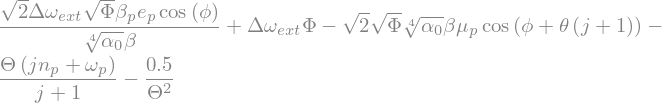

In [ ]:
# H_full = -Rational(3,2)*((j*np + omp)/(j+1))**Rational(4,3)*dTh**2 + Dom*Phi - bp/b/alpha0**Rational(1,4)*ep*Dom*sqrt(2*Phi)*cos(phi) - alpha0**Rational(5,4)*b*mup*sqrt(2*Phi)*cos((j+1)*th+phi)
H_full = (
    -1 / 2 / Th**2
    - (j * np + omp) / (j + 1) * Th
    + Dom * Phi
    + bp / b / alpha0 ** Rational(1, 4) * ep * Dom * sqrt(2 * Phi) * cos(phi)
    - alpha0 ** Rational(1, 4) * b * mup * sqrt(2 * Phi) * cos((j + 1) * th + phi)
)
H_full

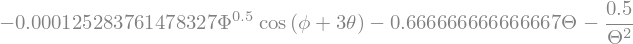

In [329]:
H_plug = H_full.subs(params).evalf()
H_plug

In [330]:
P, Q, p, q = symbols("P Q p q")

In [ ]:
_S = P * (phi + 3 * th) + Q * 3 * th
_S

In [332]:
q_expr = _S.diff(Q)
display(q_expr)
p_expr = _S.diff(P)
display(p_expr)
Phi_expr = _S.diff(phi)
display(Phi_expr)
dTh_expr = _S.diff(th)
display(dTh_expr)

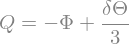

In [ ]:
Eq(Q, solve(dTh_expr - dTh, Q)[0].subs({P: Phi}))

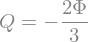

In [ ]:
Eq(Q, solve(dTh_expr - Phi_expr, Q)[0].subs({P: Phi}))

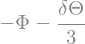

In [ ]:
solve(dTh_expr + dTh, Q)[0].subs(P, Phi)

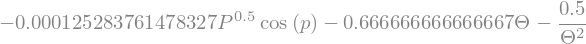

In [ ]:
H_podf = (
    H_plug.subs({Phi: Phi_expr, phi: p - 3 * th, dTh: dTh_expr}).expand().subs(Q**2, 0)
)
H_podf

Stable point is at $p=\pi$ from numerical integrations

In [ ]:
_Peq_poly = (H_podf.diff(P).subs(p, npy.pi) * P).expand()
display(_Peq_poly)
_Peq_poly = lambdify([P, Q], _Peq_poly)

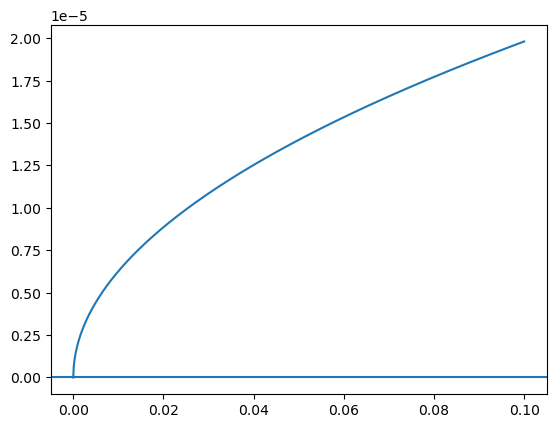

In [ ]:
_ = npy.linspace(0, 0.1, 1000)
plt.clf()
plt.plot(_, _Peq_poly(_, -0.02))
plt.axhline(y=0)
plt.show()

In [ ]:
print(params[mup] ** (2.0 / 3))
print(params[mup] ** (4.0 / 3))

0.0013572088082974539
1.8420157493201947e-06


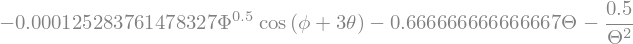

In [340]:
H_plug

In [ ]:
arg = [Phi, Th, phi, th]
display(arg)
funs = [
    -H_plug.diff(phi),
    -H_plug.diff(th),
    H_plug.diff(Phi),
    H_plug.diff(Th),
]
funs
_funs = [lambdify(arg, _f) for _f in funs]


def rhs(t, Y):
    return (_funs[0](*Y), _funs[1](*Y), _funs[2](*Y), _funs[3](*Y))

In [342]:
0.03**2

In [ ]:
initconds = {
    Phi: 0.00962670914267542,
    Th: 1.1464674303878837,
    phi: 3.0762599821533154,
    th: 0.04733059643605486,
}
y0 = [float(a.subs(initconds)) for a in arg]
_H_plug = lambdify(arg, H_plug)
_H0 = _H_plug(*y0)
_H0
print(y0)

[0.00962670914267542, 1.1464674303878837, 3.0762599821533154, 0.04733059643605486]


In [ ]:
def event_th(t, Y):
    return (Y[3] + npy.pi) % (2 * npy.pi) - npy.pi


teval = npy.linspace(0, 2 * npy.pi * 1e5, 10000)
sol = sp.integrate.solve_ivp(
    rhs,
    [teval[0], teval[-1]],
    y0,
    t_eval=teval,
    rtol=1e-12,
    atol=1e-12,
    method="DOP853",
    events=[event_th],
)

In [ ]:
initconds2 = {
    Th: 1.1464674303878837,
    phi: 2,
    th: 0.04733059643605486,
}
_H = lambda x: _H_plug(x, initconds2[Th], initconds2[phi], initconds2[th]) - _H0
initconds2[Phi] = brentq(_H, 0, 0.1)
print(initconds2[Phi])
y02 = [float(a.subs(initconds2)) for a in arg]
_H_plug2 = lambdify(arg, H_plug)
_H02 = _H_plug(*y0)
_H02
print(y02)

0.03274234861374537
[0.03274234861374537, 1.1464674303878837, 2.0, 0.04733059643605486]


In [ ]:
def event_th(t, Y):
    return (Y[3] + npy.pi) % (2 * npy.pi) - npy.pi


teval = npy.linspace(0, 2 * npy.pi * 1e5, 10000)
sol2 = sp.integrate.solve_ivp(
    rhs,
    [teval[0], teval[-1]],
    y02,
    t_eval=teval,
    rtol=1e-12,
    atol=1e-12,
    method="DOP853",
    events=[event_th],
)

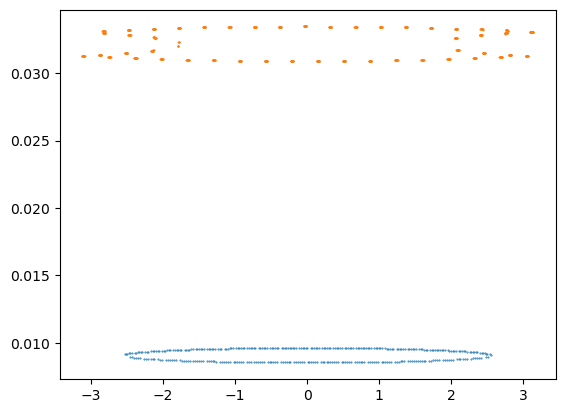

In [ ]:
plt.clf()
plt.scatter(
    (3 * sol.y_events[0][:, 2] + sol.y_events[0][:, 2] + npy.pi) % (2 * npy.pi)
    - npy.pi,
    sol.y_events[0][:, 0],
    s=0.2,
)
plt.scatter(
    (3 * sol2.y_events[0][:, 2] + sol2.y_events[0][:, 2] + npy.pi) % (2 * npy.pi)
    - npy.pi,
    sol2.y_events[0][:, 0],
    s=0.2,
)
# plt.scatter(sol.t, sol.y[0],s=0.2)
# plt.scatter(sol.t, (sol.y[2]+3*sol.y[3])%(2*npy.pi),s=0.2)
# plt.scatter(sol.t, _H_plug(sol.y[0,:],sol.y[1,:],sol.y[2,:],sol.y[3,:]))
plt.show()

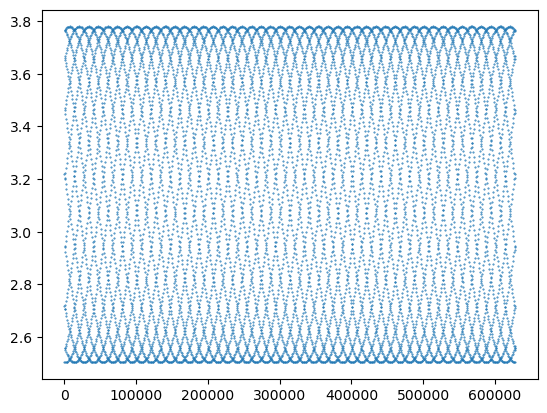

In [ ]:
plt.clf()
plt.scatter(sol.t, (sol.y[2, :] + (params[j] + 1) * sol.y[3]) % (2 * npy.pi), s=0.2)
# plt.scatter(sol.t, sol.y[3]%(2*npy.pi),s=0.2)
plt.show()

ZeroDivisionError: float division by zero

<Figure size 640x480 with 0 Axes>

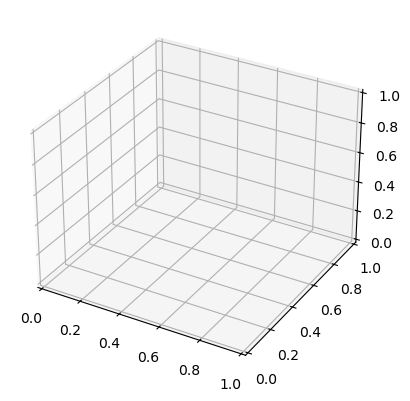

In [ ]:
plt.clf()
_1, _2 = npy.meshgrid(npy.linspace(0, 2 * npy.pi, 1000), npy.linspace(0, 0.001, 1000))
plt.figure().add_subplot(111, projection="3d").contour3D(
    _1, _2, _H_plug(_2, 0, _1, 0), cmap="viridis"
)
plt.show()

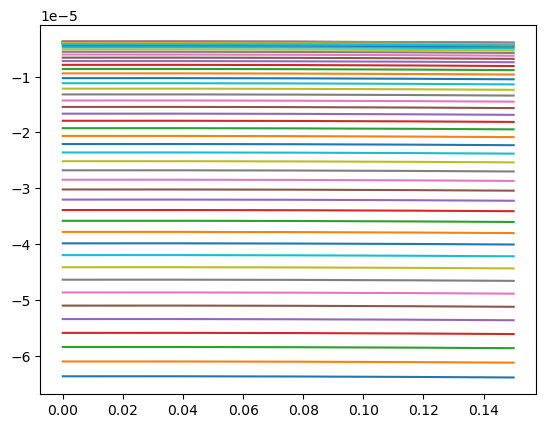

In [ ]:
plt.clf()
for Th_val in npy.linspace(1.1464674303878837 - 0.005, 1.1464674303878837 - 0.001):
    initconds = {
        Th: Th_val,
        Phi: 0.000962670914267542,
        phi: 3.0762599821533154,
    }
    _H = lambda x: _H_plug(initconds[Phi], initconds[Th], initconds[phi], x) - _H0
    plt.plot(
        npy.linspace(0, 0.15, 1000), _H(npy.linspace(0, 0.15, 1000)), label=f"{Th_val}"
    )
# plt.legend()
plt.show()

In [ ]:
%matplotlib inline

In [ ]:
plt.clf()
for Th_val in npy.linspace(1.1464674303878837 - 0.002, 1.1464674303878837 - 0.001, 10):
    initconds = {
        Th: Th_val,
        Phi: 0.00962670914267542,
        phi: 3.0762599821533154,
    }
    _H = lambda x: _H_plug(initconds[Phi], initconds[Th], initconds[phi], x) - (
        _H0 - 0.00002
    )
    initconds[th] = brentq(_H, 0, 0.2)
    found = False
    for _x1, _x2 in zip(
        npy.linspace(0, 0.15, 100)[:-1], npy.linspace(0, 0.15, 100)[1:]
    ):
        if _H(_x1) < 0 and _H(_x2) > 0:
            initconds[th] = brentq(_H, _x1, _x2)
            found = True
            break
    # if not found:
    #    plt.clf()
    #    plt.plot(npy.linspace(0,0.15,1000), _H(npy.linspace(0,0.15,1000)))
    #    plt.show()
    #    raise Warning("Root not found")
    y0 = [float(a.subs(initconds)) for a in arg]
    _H_plug = lambdify(arg, H_plug)
    print(_H_plug(*y0), initconds[th])

    def event_th(t, Y):
        return (Y[3] + npy.pi) % (2 * npy.pi) - npy.pi

    event_th.direction = 1
    teval = npy.linspace(0, 2 * npy.pi * 1e5, 10000)
    sol = sp.integrate.solve_ivp(
        rhs,
        [teval[0], teval[-1]],
        y0,
        t_eval=teval,
        rtol=1e-12,
        atol=1e-12,
        method="DOP853",
        events=[event_th],
    )
    plt.scatter(
        (3 * sol.y_events[0][:, 2] + sol.y_events[0][:, 2] + npy.pi) % (2 * npy.pi)
        - npy.pi,
        sol.y_events[0][:, 0],
        s=0.2,
    )
plt.title(
    r"Poincaire section for different $\Theta_0$ values"
    + "\n"
    + r"$\omega_p-\omega=$"
    + f"{params[omp]}-{params[om]}"
)
plt.show()

ValueError: f(a) and f(b) must have different signs

<Figure size 640x480 with 0 Axes>

In [ ]:
phi
Phi

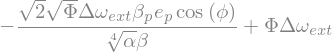

In [ ]:
H_phi_expr = Dom * Phi - sqrt(2 * Phi) * bp * ep * Dom / alpha ** Rational(
    1, 4
) / b * cos(phi)
H_phi_expr

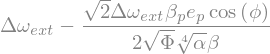

In [ ]:
H_phi_expr.diff(Phi)

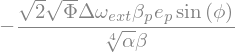

In [ ]:
-H_phi_expr.diff(phi)

In [ ]:
params = {
    Dom: 0.01,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    ep: 0.1,
    alpha: alpha0val,
}

In [ ]:
_f = [H_phi_expr.diff(Phi), -H_phi_expr.diff(phi)]
_f = [_i.subs(params).evalf() for _i in _f]
funcl = lambdify([phi, Phi], _f)


def rhs(t, Y):
    return _f(*Y)

In [ ]:
sol = sp.integrate.solve_ivp(
    rhs,
    [teval[0], teval[-1]],
    [0, 0.01],
    t_eval=teval,
    rtol=1e-12,
    atol=1e-12,
    method="DOP853",
    events=[event_th],
)

# Stability of original resonant EOM for $\theta_p$

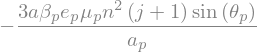

In [ ]:
ndot_p = ndot.subs(e, 0)
ndot_p

In [ ]:
thpdot_p = thpdot.subs(e, 0)
thpdot_p

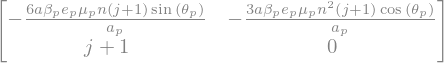

In [ ]:
args = [n, thp]
_M = []
for _f in [ndot_p, thpdot_p]:
    _M += [[_f.diff(_) for _ in args]]
_M = Matrix(_M)
_M

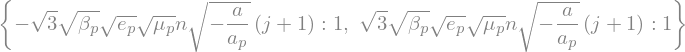

In [ ]:
_M.subs(thp, 0).eigenvals()

# Analytical stability

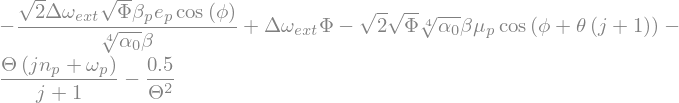

In [ ]:
H_full

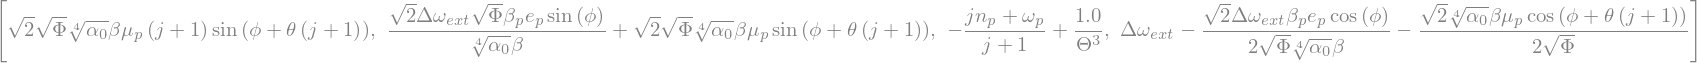

In [ ]:
X_full = [H_full.diff(th), H_full.diff(phi), H_full.diff(Th), H_full.diff(Phi)]
X_full

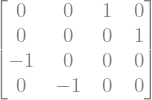

In [ ]:
J_full = Matrix([[0, 0, 1, 0], [0, 0, 0, 1], [-1, 0, 0, 0], [0, -1, 0, 0]])
J_full

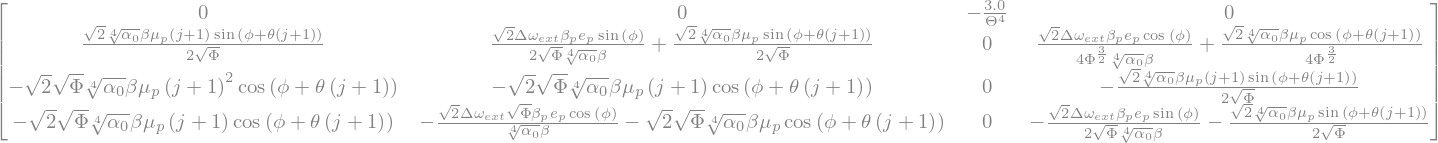

In [ ]:
Y_full = []
for _var in [th, phi, Th, Phi]:
    Y_full += [[X_full[i].diff(_var) for i in range(len(X_full))]]
Y_full = J_full * Matrix(Y_full)
Y_full

# $\mu_p=0$ resonance

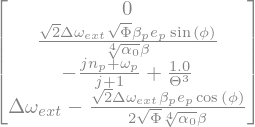

In [ ]:
Matrix(X_full).subs(mup, 0)

$\phi=0,\pi$ 

From the last equation ($\dot\Phi=0$) need $\phi=0$

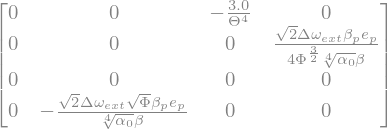

In [ ]:
_ = Matrix(Y_full).subs(mup, 0).subs(phi, 0)
_

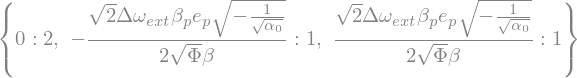

In [ ]:
_.eigenvals()

✅ stable since eigenvalues are purely imaginary

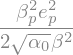

In [ ]:
Phi_mup0 = solve(Matrix(X_full).subs(mup, 0)[3].subs(phi, 0), Phi)[0]
Phi_mup0

# $e_p=0$ resonance

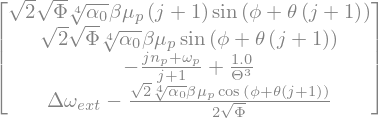

In [ ]:
Matrix(X_full).subs(ep, 0)

Not sure this actually works. It only considers the $\theta$ and $\phi$ angles separately. Does the story change if you do the canon transforms to a single angle? It would become nonlinear?

See below, it def matters that it becomes nonlinear

~~Then $(j+1)\theta+\phi=0,\pi$~~

~~From last equation $(j+1)\theta + \phi=0$~~

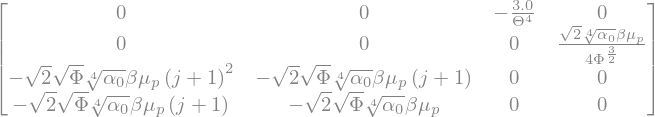

In [ ]:
_ = Matrix(Y_full).subs(ep, 0).subs((j + 1) * th + phi, 0)
_

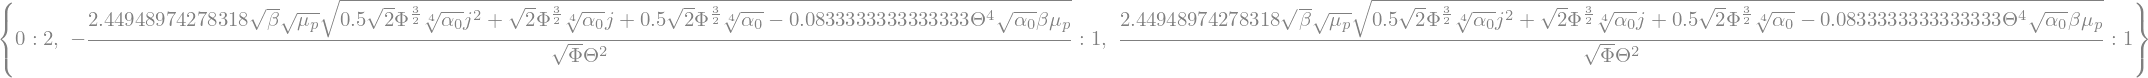

In [ ]:
_.eigenvals()

If $\Phi^{3/2}\gg \mu_p$ then possibly unstable?

~~✅ stable since eigenvalues are purely imaginary~~

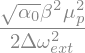

In [ ]:
Phi_ep0 = solve(Matrix(X_full).subs(ep, 0).subs(phi + (j + 1) * th, 0)[3], Phi)[0]
Phi_ep0

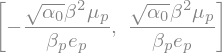

In [ ]:
solve(Phi_ep0 - Phi_mup0, Dom)

# Separatrices

## $\phi$

Drop the $\delta\Theta^2$ term (its constant)

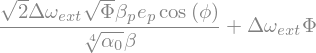

In [ ]:
H_phi = Dom * Phi + bp / b / alpha0 ** Rational(1, 4) * ep * Dom * sqrt(2 * Phi) * cos(
    phi
)
H_phi

In [ ]:
solve(H_phi.subs(params).evalf().diff(Phi).subs(phi, pi), Phi)

In [372]:
%matplotlib widget

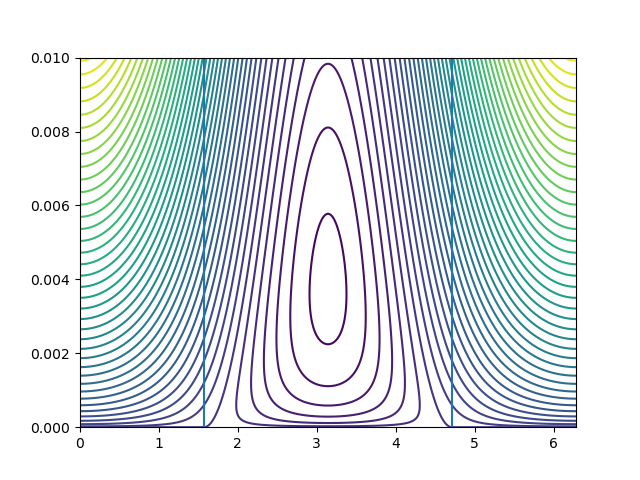

In [ ]:
plt.clf()
params = {
    mup: 1e-3,
    Dom: 0.01,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    ep: 0.1,
    alpha0: alpha0val,
}
_f = lambdify([phi, Phi], H_phi.subs(params).evalf())
_x, _y = npy.meshgrid(npy.linspace(0, 2 * npy.pi, 1000), npy.linspace(0, 0.01, 1000))
plt.contour(_x, _y, _f(_x, _y), levels=50)
plt.axvline(x=npy.pi / 2)
plt.axvline(x=3 * npy.pi / 2)
plt.show()

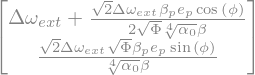

In [ ]:
X_full = Matrix([H_phi.diff(Phi), -H_phi.diff(phi)])
X_full

Looks like $\phi\to\pi/2, 3\pi/2$ and $\Phi\to 0$ for the value of the separatrix?

In [ ]:
H_phi.subs(params).subs(phi, pi / 2).subs(Phi, 0)

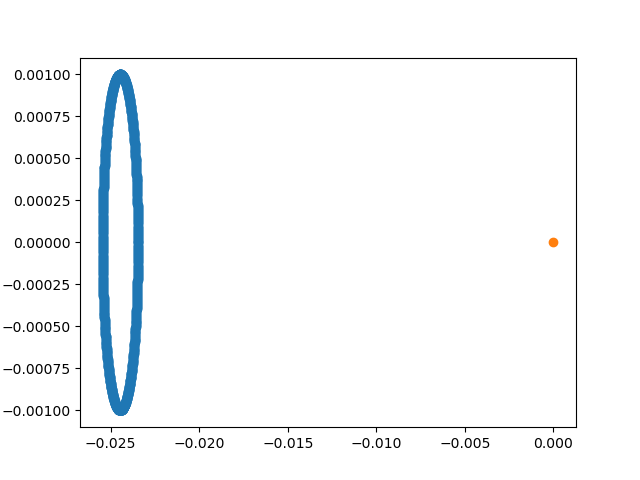

In [432]:
plt.clf()
plt.scatter(
    0.001 * npy.cos(-varpi0) - params[bp] / params[b] * 0.03,
    0.001 * npy.sin(-varpi0),
)
plt.scatter(0,0)
# plt.plot(varpi0,0.001 * npy.sin(-varpi0))
# plt.plot(varpi0, 0.001 * npy.cos(-varpi0) - params[bp] / params[b] * 0.03)
plt.show()

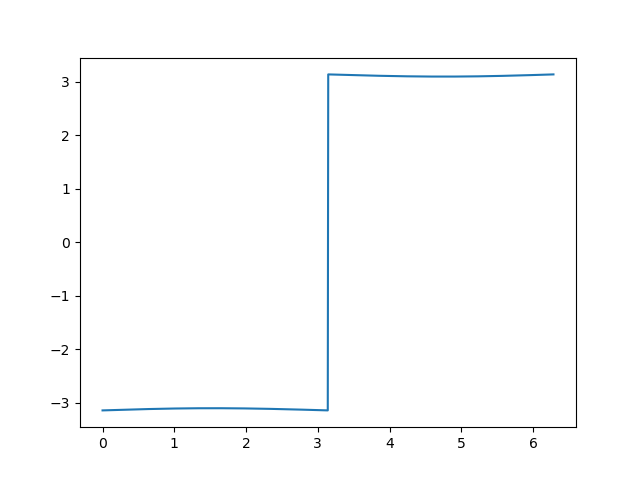

In [427]:
plt.clf()
varpi0 = npy.linspace(0, 2 * npy.pi, 1000)
plt.plot(
    varpi0,
    npy.arctan2(
        0.001 * npy.sin(-varpi0),
        0.001 * npy.cos(-varpi0) - params[bp] / params[b] * 0.03,
    ),
)
plt.show()

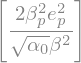

In [ ]:
solve(H_phi.subs(phi, pi), Phi)

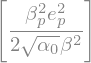

In [420]:
solve(X_full[0].subs(phi,pi),Phi)

In [610]:
solve(X_full[0].subs(phi, pi), Phi)[0].subs(
    {
        bp: 1.5455341716765871,
        alpha0:alpha0val,
        b: 1.8956507412695471,
    }
)

In [613]:
1/0.064*0.35

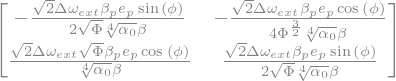

In [ ]:
args = [phi, Phi]
_M = []
for _f in X_full:
    _M += [[_f.diff(arg) for arg in args]]
_M = Matrix(_M)
_M

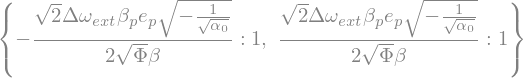

In [ ]:
_M.subs(phi, pi).eigenvals()

## $\phi_1=(j+1)\theta+\phi$

~~from above, have one equilibrium at $\phi_1=0$ (unclear if stable or not)~~

In [620]:
J2, phi1 = symbols("J_2 phi_1")
J1, A = symbols("J_1 A",positive=True)

In [621]:
J1_expr = Phi
Eq(J1, J1_expr)

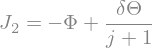

In [622]:
J2_expr = dTh / (j + 1) - Phi
Eq(J2, J2_expr)

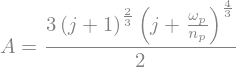

In [623]:
A_expr = Rational(3, 2) * ((j + omp/np) / (j + 1)) ** Rational(4, 3) * (j + 1) ** 2
Eq(A, A_expr)

In [624]:
H_phi1 = (
    -A * (J1 + J2) ** 2
    + Dom * J1
    - alpha0 ** Rational(1, 4) * b * mup * sqrt(2 * J1) * cos(phi1)
)
H_phi1 = H_phi1.expand().subs(J2**2, 0).collect(J1)  # .subs(A,A_expr)
H_phi1

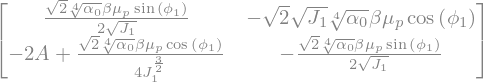

In [625]:
X_full = [H_phi1.diff(J1),-H_phi1.diff(phi1)]
args = [phi1,J1]
_M = []
for arg in args:
    _M += [[X_full[i].diff(arg) for i in range(len(args))]]
_M = Matrix(_M)
_M

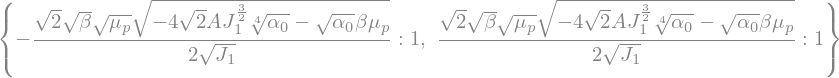

In [626]:
_M.subs(phi1,pi).eigenvals()

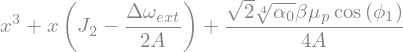

In [530]:
_poly = (H_phi1.diff(J1)/(-2*A)*sqrt(J1)).expand().collect(sqrt(J1)).subs(sqrt(J1),x)
_poly

In [531]:
A_expr.subs({j:2, np:1, omp:0.}).evalf()

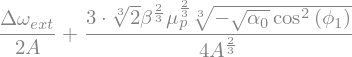

In [532]:
J2_crit = solve(discriminant(_poly),J2)[2].subs(
    {
        #phi1: 0,
        #b: 1.8956507412695471,
        #alpha0:alpha0val,
    }
).simplify()#.subs((-1)**Rational(1,3),-1)#.subs(omp,0).evalf()
J2_crit

In [605]:
J2_crit.subs({
        b: 1.8956507412695471,
        A: 7.86222418262669,
}).evalf()

In [606]:
0.3661*alpha0val**(1/6)

In [593]:
J2_crit.subs(
    {
        Dom:1e-4,
        phi1: 0,
        b: 1.8956507412695471,
        alpha0:alpha0val,
        A: 7.86222418262669,
        mup:5e-5,
    }
).subs((-2)**Rational(1,3),-2**(1./3))#.evalf()

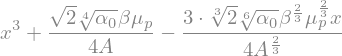

In [636]:
_poly_crit = _poly.subs(J2,J2_crit).subs(phi1,0).subs((-sqrt(alpha0))**Rational(1,3),-alpha0**Rational(1,6))
_poly_crit

In [637]:
discriminant(_poly_crit)

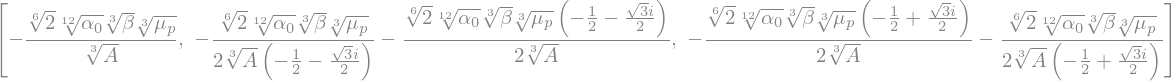

In [638]:
solve(_poly_crit,x)

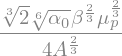

In [641]:
J1_sep = -3*_poly_crit.subs(x,0)/2/_poly_crit.coeff(x)
J1_sep**2

In [576]:
J1_sep.subs(ps).evalf()

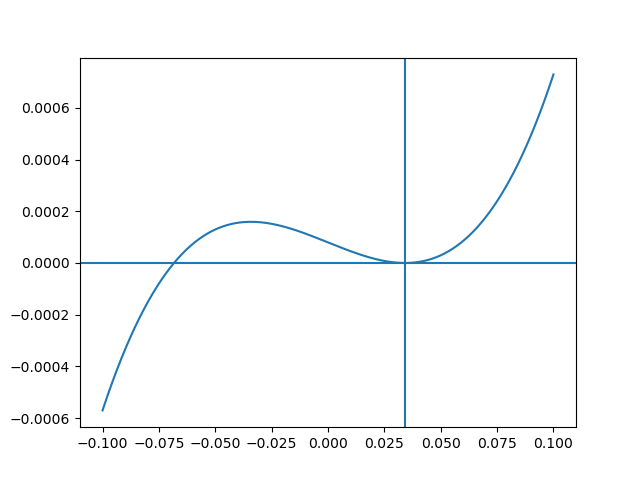

In [579]:
plt.clf()
ps = {
    b: 1.8956507412695471,
    alpha0: alpha0val,
    mup: 1e-3,
    A: 7.86222418262669,
}
_f = _poly_crit.subs(ps).evalf()
display(_f)
_f = lambdify(x, _f)
_x = npy.linspace(-0.1, 0.1, 1000)
plt.plot(_x, _f(_x))
plt.axhline(y=0)
plt.axvline(x=J1_sep.subs(ps).evalf())
plt.show()

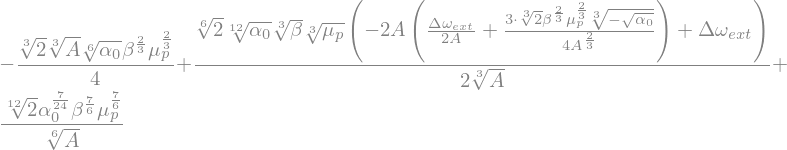

In [602]:
H_sep = H_phi1.subs(J2, J2_crit).subs(J1, J1_sep).subs(phi1, pi)
H_sep

In [544]:
A_expr.subs({j:2,omp:0}).evalf()

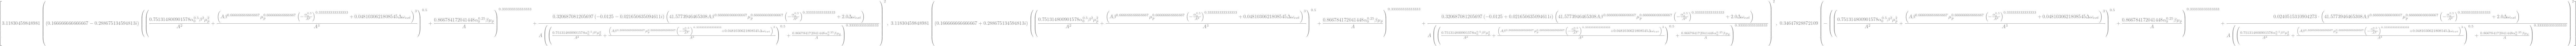

In [ ]:
solve((H_phi1.diff(J1)/(-2*A)*sqrt(J1)).subs(J2,J2_crit*1.1).subs(
    {
        phi1: 0,
        b: 1.8956507412695471,
        alpha0:alpha0val,
    }
).simplify(),J1)

Unstable branch

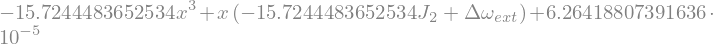

In [417]:
_poly = (H_phi1.diff(J1) * sqrt(J1)).expand().subs(sqrt(J1), x).collect(x).subs(
    {
        phi1: pi,
        A: A_expr.subs({j:2, np:1, omp:0.}).evalf(),
        b: 1.8956507412695471,
        alpha0:alpha0val,
        mup:5e-5
    }
).evalf()
_poly

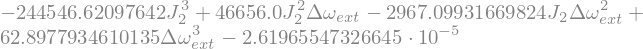

In [ ]:
discriminant(_poly,x)

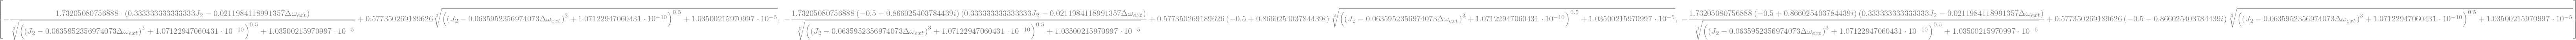

In [416]:
solve(_poly,x)